In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import os, sys, scipy
import h5py
from astropy import units as u
import specutils, astropy, ccdproc
from tqdm import tqdm_notebook
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation
from math import log10
from astropy.nddata import CCDData
import ccdproc as ccdp
from astropy.table import Table

import warnings
warnings.filterwarnings("ignore")

plt.rcParams['font.size'] = 15
parula_colors = np.load('/Users/arcticfox/parula_colors.npy')


In [2]:
RAW_DIR = '/Users/arcticfox/Documents/atmospheres/v1298tau/calibration/'

RAW_FILES = np.sort([os.path.join(RAW_DIR, i) for i in 
                             os.listdir(RAW_DIR) 
                             if i.endswith('.bz2')])

In [3]:
fb = h5py.File('/Users/arcticfox/Documents/atmospheres/v1298tau/masks/telluric_model_b.hdf', 'r')
fr = h5py.File('/Users/arcticfox/Documents/atmospheres/v1298tau/masks/telluric_model_r.hdf', 'r')

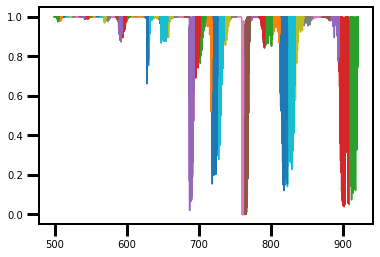

In [4]:
for keys in list(fb['wavelength_solution']['fiber_2'].keys()):
    plt.plot(np.array(fb['wavelength_solution']['fiber_2'][keys]),
             np.array(fb['telluric_model']['fiber_2'][keys]))
for keys in list(fr['wavelength_solution']['fiber_2'].keys()):
    plt.plot(np.array(fr['wavelength_solution']['fiber_2'][keys]),
             np.array(fr['telluric_model']['fiber_2'][keys]))

In [5]:
def resave(files, dir):
    
    times = np.array([])
    
    for fn in tqdm_notebook(files):
        name = fn.split('.')[0]
        hdu = fits.open(fn)
        dattype = hdu[0].header['OBSTYPE']
        
        if hdu[0].header['EREADSPD'] == 'Normal: 4.15e noise, 1.30e/ADU, 19s':
            np.save('{0}_{1}.npy'.format(name, dattype), hdu[0].data)
            if dattype == 'OBJECT':
                times = np.append(times, hdu[0].header['MJDATE'])
        hdu.close()
        
    if len(times) > 0:
        np.save(os.path.join(dir, 'mjddates.npy'), times)
        
    return times

In [6]:
#resave(RAW_FILES)
new_science_dir = '/Users/arcticfox/Downloads/gemini_data/'
NEW_SCIENCE_FILES = np.sort([os.path.join(new_science_dir, i) for i in
                             os.listdir(new_science_dir) if i.endswith('.fits')])
TIMES = resave(NEW_SCIENCE_FILES, new_science_dir)

In [7]:
len(TIMES)

53

In [8]:
files = os.listdir(RAW_DIR)

SCIENCE_FRAMES = np.sort([os.path.join(new_science_dir, i) for i in 
                          os.listdir(new_science_dir) if i.endswith('OBJECT.npy')])
BIAS_FRAMES = np.sort([os.path.join(RAW_DIR, i) for i in 
                       files if i.endswith('_BIAS.npy')])
FLAT_FRAMES = np.sort([os.path.join(RAW_DIR, i) for i in 
                       files if i.endswith('_FLAT.npy')])
ARC_FRAMES = np.sort([os.path.join(RAW_DIR, i) for i in 
                      files if i.endswith('_ARC.npy')])

TIMES = np.load(os.path.join(new_science_dir,'mjddates.npy'), 
                allow_pickle=True)

## Creating the Master Dark

In [9]:
def master_file(files, output_fn):
    global DATA_DIR
    arrs = []
    for fn in tqdm_notebook(files):
        d = np.load(fn, allow_pickle=True)
        arrs.append(d)
    arrs = np.array(arrs)
    meddark = np.nanmedian(arrs, axis=0)
    np.save(os.path.join(new_science_dir, output_fn), meddark)
    return meddark

MEDDARK = master_file(BIAS_FRAMES, 'master_dark.npy')
MEDFLAT = master_file(FLAT_FRAMES, 'master_flat.npy')

In [10]:
MEDDARK = np.load(os.path.join(RAW_DIR, 'master_dark.npy'))
MEDFLAT = np.load(os.path.join(RAW_DIR, 'master_flat.npy'))

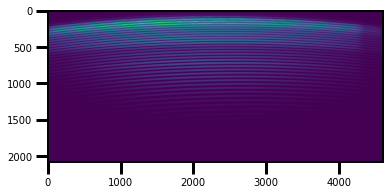

In [11]:
plt.imshow(MEDFLAT.T)

## Subtracting master dark from every file

In [12]:
def subtract_dark(files):
    global MEDDARK
    
    for fn in tqdm_notebook(files):
        d = np.load(fn, allow_pickle=True)
       # plt.imshow(d.T, origin='lower', vmin=np.nanpercentile(d,15),
       #          vmax=np.nanpercentile(d,85))
       # plt.show()
        name = fn[:-4] + '_biasSub.npy'
        np.save(name, d - MEDDARK)
        
subtract_dark(SCIENCE_FRAMES)
#subtract_dark(FLAT_FRAMES)
#subtract_dark(ARC_FRAMES)

## Divide out Master Flat

In [13]:
# column median order by order and smooth and divide out of flat field row by row
# gets pixel-to-pixel sensitivity variations and divide that out

def flat_removal(files):
    global MEDFLAT
    for fn in tqdm_notebook(files):
        d = np.load(fn[:-4]+'_biasSub.npy', allow_pickle=True)
        name = fn[:-4] + '_biasSub_flatSub.npy'
        np.save(name, d/MEDFLAT)

flat_removal(SCIENCE_FRAMES)

## Extracting the orders

In [14]:
for i, fn in enumerate(SCIENCE_FRAMES):
    name = fn[:-4] + '_biasSub_flatSub.npy'
    d = np.load(name, allow_pickle=True)
    if i == 0:
        SUMMEDFRAME = np.load(name, allow_pickle=True)
    else:
        SUMMEDFRAME += np.load(name, allow_pickle=True)

<IPython.core.display.Javascript object>


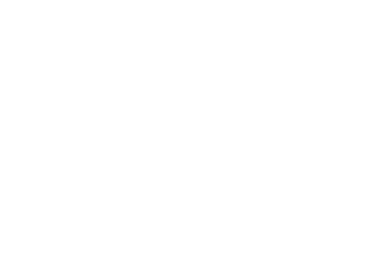

<IPython.core.display.Javascript object>


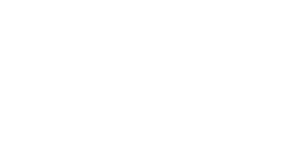

In [71]:
plt.imshow(SUMMEDFRAME.T, vmax=30)
plt.colorbar()

In [15]:
def group_inds(values):
    results = []

    for i, v in enumerate(values):
        if i == 0:
            mini = maxi = v
            temp = [v]
        else:
            # SETS 10 CADENCE LIMIT                                                                                                                    
            if (np.abs(v-maxi) < 7):
                temp.append(v)
                if v > maxi:
                    maxi = v
                if v < mini:
                    mini = v
            else:
                results.append(temp)
                mini = maxi = v
                temp = [v]

            # GETS THE LAST GROUP                                                                                                                     
            if i == len(values)-1:
                results.append(temp)

    return np.array(results)

In [16]:
def find_gap_middle(midcol_dat):
    x = np.arange(len(midcol_dat))
    
    plt.figure(figsize=(14,4))

    plt.plot(x, midcol_dat, 'w')

    filt = scipy.ndimage.filters.minimum_filter1d(midcol_dat,
                                             size=30)

    fit = np.polyfit(x, filt, deg=8)
    model = np.poly1d(fit)
    midcol_fit = model(x)

    dists = np.sqrt((midcol_fit-midcol_dat)**2)
    minima = np.where((dists <= np.nanmin(dists) + 0.3*np.nanstd(dists)))[0]

    plt.plot(x[minima], midcol_fit[minima], 'b.')
#    plt.plot(x, midcol_fit, 'k')

    medminima = group_inds(minima)

    starting_x, starting_y = [], []
    
    for m in medminima:
        ind = np.nanmedian(m)
#        print(ind)
#        if ind % 1 == 0:
#            starting_x.append(x[int(ind)])
#            starting_y.append(midcol_dat[int(ind)])
#       else:
        floor, ceil = int(np.floor(ind)), int(np.ceil(ind))
        starting_x.append(np.nanmean([x[floor], x[ceil]]))
        starting_y.append(np.nanmean([midcol_dat[floor],
                                          midcol_dat[ceil]]))


    starting_x = np.array(starting_x[1:-1])
    starting_y = np.array(starting_y[1:-1])

    plt.plot(starting_x, starting_y, 'ro')
    plt.ylim(-1,40)
    # Ben doubted himself with the argmin 02/03/2020
    plt.show()
    
    return starting_x, starting_y

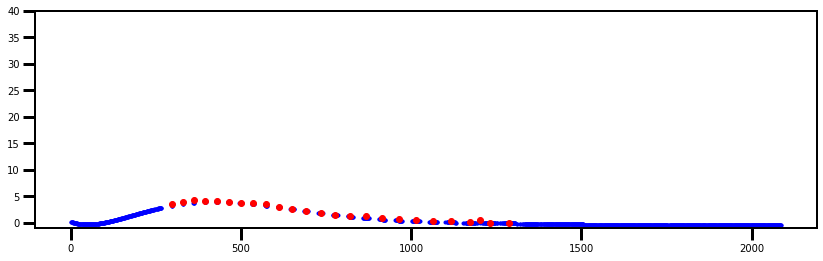

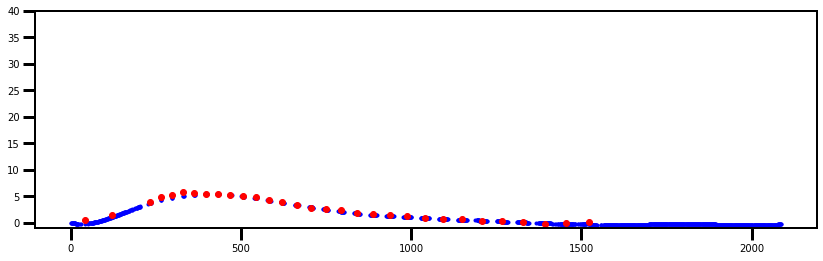

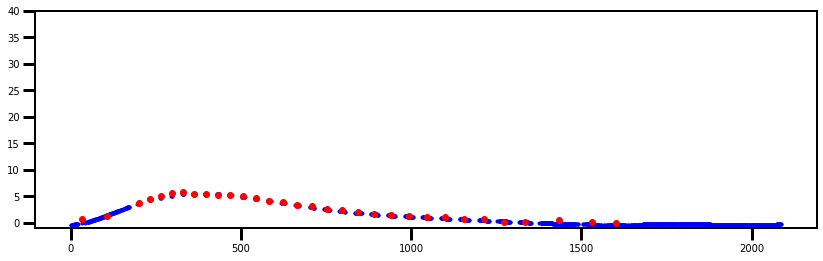

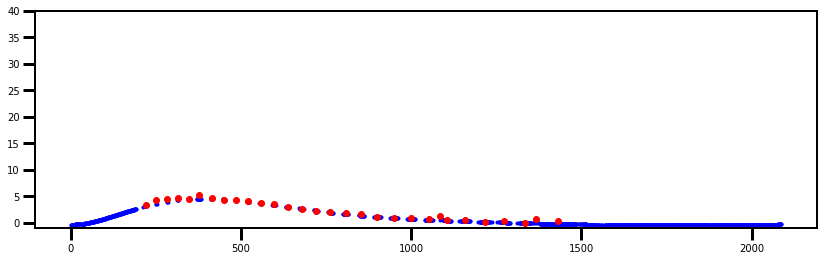

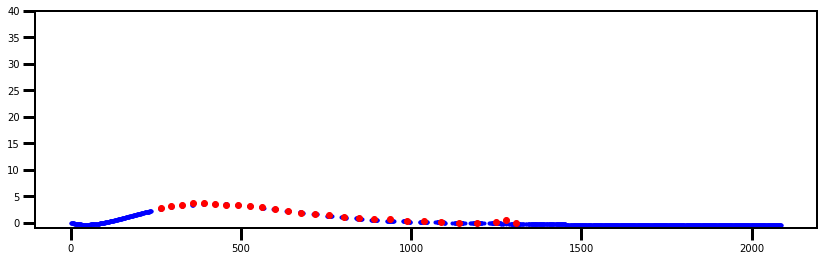

In [17]:
%matplotlib inline

midcol = int(SUMMEDFRAME.shape[0]/2)

midcol_dat = SUMMEDFRAME[midcol:midcol+1][0]
tip_x, tip_y = find_gap_middle(SUMMEDFRAME[500:501][0])
start_x, start_y = find_gap_middle(SUMMEDFRAME[midcol-1000:midcol-999][0])

middle_x, middle_y = find_gap_middle(midcol_dat)
end_x, end_y = find_gap_middle(SUMMEDFRAME[midcol+1000:midcol+10001][0])
butt_x, butt_y = find_gap_middle(SUMMEDFRAME[4000:4001][0])

In [18]:
diff = np.diff([136, 172, 201])
cumsum = np.cumsum(diff)

tip_start, start_start = 197, 136
mid_start, end_start   = 101, 123
butt_start = 171
tip_x = np.sort(np.append(tip_x, np.append([tip_start], tip_start+cumsum)))
start_x = np.sort(np.append(start_x, np.append([start_start], start_start+cumsum)))
middle_x = np.sort(np.append(middle_x, np.append([mid_start], mid_start+cumsum)))
end_x = np.sort(np.append(end_x, np.append([end_start], end_start+cumsum)))
butt_x = np.sort(np.append(butt_x, np.append([butt_start], butt_start+cumsum)))

In [19]:
len(tip_x)-np.array([2,4,7])

array([26, 24, 21])

<IPython.core.display.Javascript object>


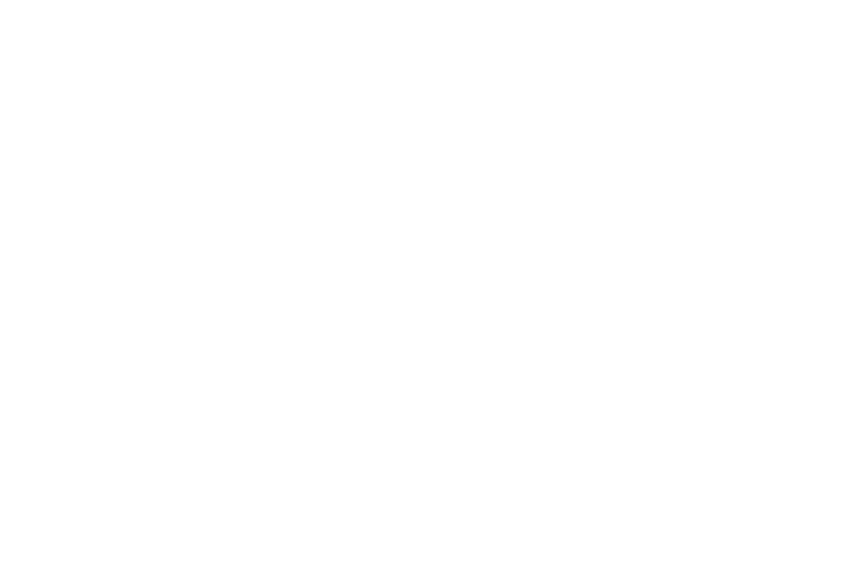

[array([ 197. ,  233. ,  262. ,  297. ,  329. ,  361.5,  394.5,  429. ,
        463.5,  498.5,  535. ,  572.5,  610.5,  650.5,  691. ,  733.5,
        776.5,  821. ,  867. ,  914.5,  963. , 1065. , 1118. , 1202. ,
       1287.5])
 array([ 136. ,  172. ,  201. ,  233. ,  265. ,  297. ,  330.5,  363. ,
        397.5,  432. ,  468. ,  505. ,  543. ,  582. ,  621.5,  663. ,
        705.5,  748.5,  794. ,  841.5,  888.5,  937.5,  988.5, 1040. ,
       1094. , 1150. , 1207. ])
 array([ 105.5,  137. ,  166. ,  200.5,  232.5,  264. ,  296.5,  329. ,
        362.5,  397. ,  432.5,  468. ,  506. ,  544. ,  583. ,  623.5,
        665. ,  708. ,  752. ,  797. ,  844.5,  891.5,  941.5,  993.5,
       1045.5, 1100. ])
 array([ 123. ,  159. ,  188. ,  219.5,  251. ,  283. ,  314.5,  347. ,
        375.5,  413.5,  449. ,  484. ,  520.5,  559. ,  597. ,  636.5,
        677.5,  719.5,  762.5,  807. ,  853.5,  900.5,  949.5,  999.5,
       1052. , 1085. , 1158.5])
 array([ 171. ,  207. ,  236. ,  263.5, 

In [20]:
%matplotlib inline
%matplotlib notebook
%matplotlib notebook

plt.imshow(SUMMEDFRAME.T, vmin=0, vmax=15)

all_points_x = np.array([tip_x[np.delete(np.arange(0,len(tip_x),1,dtype=int),
                                         len(tip_x)-np.array([2,4,7],dtype=int))],
                         start_x[2:-5],
                         middle_x[2:-7],
                         end_x[:-5][np.delete(np.arange(0,len(end_x[:-5]),1,dtype=int),
                                              len(end_x[:-5])-2)],
                         butt_x[:-4]])

print(all_points_x)
all_points_y = np.array([500,
                         int(SUMMEDFRAME.shape[0]/2-1000),
                         int(SUMMEDFRAME.shape[0]/2),
                         int(SUMMEDFRAME.shape[0]/2+1000),
                         4000])

fit_x = np.arange(0,SUMMEDFRAME.shape[0],1)

#models = np.zeros((all_points_x.shape[1], len(fit_x)))

for i in range(len(all_points_x)):
    plt.plot(np.full(len(all_points_x[i]), all_points_y[i]), all_points_x[i], '.')

#plt.colorbar()
plt.show()
plt.close()

In [80]:
for i in range(len(all_points_x)):
    print(len(all_points_x[i]))

25
27
21
28
26


In [60]:
%matplotlib inline
%matplotlib notebook
%matplotlib inline

MODELS = np.zeros((all_points_x.shape[1], len(fit_x)))
plt.imshow(SUMMEDFRAME.T, vmin=0, vmax=15)
for i in range(all_points_x.shape[1]):
    fit = np.polyfit(all_points_y, all_points_x[:,i], deg=2)
    model = np.poly1d(fit)
    MODELS[i] = model(fit_x)
    plt.plot(fit_x, model(fit_x), 'w', lw=3)

IndexError: tuple index out of range

## Discretize model gap fits

In [144]:
DISCRETE = np.zeros(MODELS.shape, dtype=int)
for i in range(len(MODELS)):
    DISCRETE[i] = np.round(MODELS[i])

In [145]:
np.save(os.path.join(RAW_DIR, 'models.npy'), MODELS)
np.save(os.path.join(RAW_DIR, 'discrete_models.npy'), DISCRETE)

## Summing the orders

In [21]:
DISCRETE = np.load(os.path.join('/Users/arcticfox/Documents/atmospheres/v1298tau/spectra_files', 
                                'discrete_models.npy'))

In [22]:
FLUXES = np.zeros((DISCRETE.shape[0]-1, len(DISCRETE[0])))

for i in range(0, DISCRETE.shape[0]-1):
    top = DISCRETE[i] + 0
    avg_height = np.nanmedian(np.abs(DISCRETE[i+1]-DISCRETE[i]))
    bottom = np.array(DISCRETE[i] + avg_height, dtype=int)
    for j in range(top.shape[0]):
        FLUXES[i][j] = np.nansum(SUMMEDFRAME[j, top[j]:bottom[j]])

## Gettin Barycentric Correction

In [23]:
def get_barycorr(files):
    global TIMES
    corr = np.zeros(len(TIMES))
    
    for i in tqdm_notebook(range(len(TIMES))):
        
        keck = EarthLocation.from_geodetic(lat=19.8283*u.deg, 
                                   lon=-155.4783*u.deg, height=4160*u.m)
        sc = SkyCoord('04:05:19.6', '+20:09:25.6', unit=(u.hourangle, u.deg))
        barycorr = sc.radial_velocity_correction('heliocentric',
                                                 obstime=Time(TIMES[i], format='mjd'), 
                                                 location=keck)
        bc = barycorr.to(u.km/u.s) 
        corr[i] = bc.value
    return corr

In [24]:
TIMES = np.load(os.path.join(new_science_dir,
                             'mjddates.npy'))
BARYCORR = get_barycorr(SCIENCE_FRAMES) * u.km / u.s

In [25]:
len(SCIENCE_FRAMES), len(BARYCORR)

(53, 53)

# Remove cosmic rays

In [26]:
NEW_FRAMES = []

for file in tqdm_notebook(SCIENCE_FRAMES):
    name = file[:-4] + '_biasSub_flatSub.npy'
    data = np.load(name, allow_pickle=True)
    
    # REMOVE COSMIC RAYS
    #ccd = CCDData(data, unit='electron')
    #ccd_removed = ccdp.cosmicray_lacosmic(ccd, sigclip=2.5)
    #data = ccd_removed.data + 0.0
    
    newname = file[:-4] + '_cr_removed.npy'
    NEW_FRAMES.append(newname)
    np.save(newname, data)

## Get Wavelength & Orders from a File

In [27]:
hdu = fits.open('/Users/arcticfox/Documents/atmospheres/v1298tau/data/N20200122G0066m.fits')
WAVELENGTH = hdu[0].data[4] * u.nm
ORDERS = hdu[0].data[0]
REFFLUX = hdu[0].data[10]
hdu.close()

## Matching Wavelengths

In [28]:
nisttable = Table.read('nist.txt', format='csv')
nistlines = np.zeros(len(nisttable))
nintensity = np.zeros(len(nisttable))
for i, ln in enumerate(nisttable['obs_wl_air(nm)']):
    nistlines[i] = float(ln[2:-1])
    try:
        nintensity[i] = nisttable['intens'][i][2:4]
    except:
        nintensity[i] = nisttable['intens'][i][2:3]

<IPython.core.display.Javascript object>


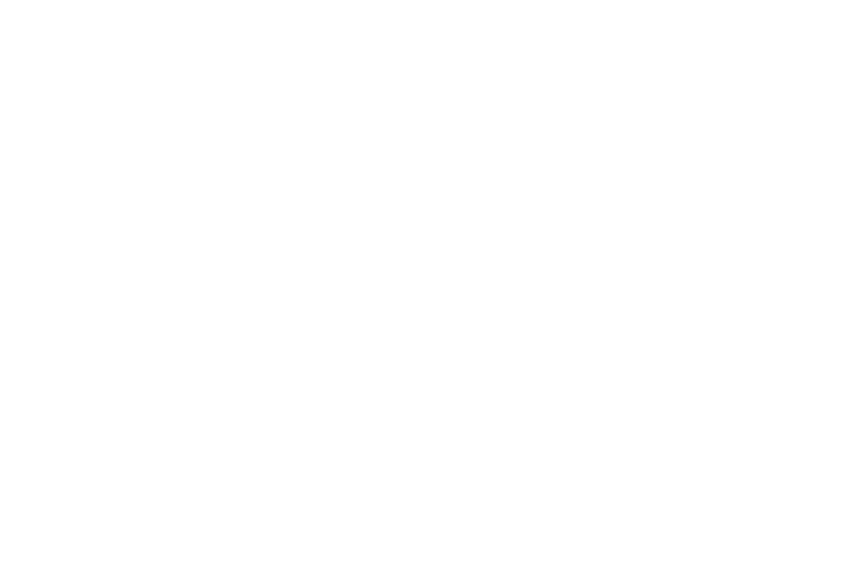

<IPython.core.display.Javascript object>


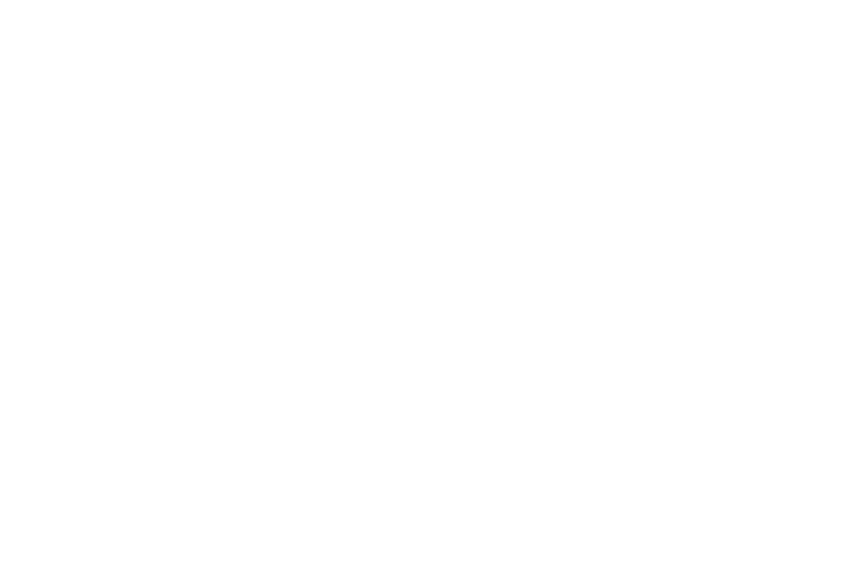

In [29]:
norders = np.array([], dtype=int)
telluric_contam = np.zeros(len(nisttable))
for i,ln in enumerate(nistlines):
    q = np.where((WAVELENGTH.value<=ln+1) & (WAVELENGTH.value>=ln-1))[0]
    plt.plot(WAVELENGTH[q], REFFLUX[q])
    plt.title('line = {0} nm; intensity = {1}'.format(ln, nintensity[i]))
    plt.vlines(ln, 0, 10, 'darkorange')
    plt.ylim(np.nanmin(REFFLUX[q]), np.nanmax(REFFLUX[q]))
    plt.show()
    norders = np.append(norders, np.unique(ORDERS[q]))
    if np.nanmin(REFFLUX[q]) < 0.4:
        telluric_contam[i] = 1.0

In [30]:
ORDER_START = 23
CUT_END = 350

In [31]:
lines = Table.read('/Users/arcticfox/Downloads/gemini_data/fraunhofer.txt', 
                   format='ascii')
lines.add_row(['HeI', 587.5618, 587.5618, 14])
lines.add_row(['HeI', 587.5618, 587.5618, 16])

In [66]:
orders = np.unique(lines['index'])

In [33]:
def extract_data(file, barycorr):
    global REDUCED_DIR, WAVELENGTH, ORDERS, ORDER_START, CUT_END, DISCRETE
    
    fit_x = np.arange(0,SUMMEDFRAME.shape[0],1)

    # LOAD IN DATA
    data = np.load(name, allow_pickle=True)

    # BARYCENTRIC CORRECTION
    speedlight = 2.998e8 * u.m / u.s
    dopshift = ((WAVELENGTH * barycorr) / speedlight).to(u.nm)
    wavelength = (WAVELENGTH - dopshift).to(u.nm).value
    
    # SUM FLUXES BETWEEN ORDERS
    fluxes = np.zeros((DISCRETE.shape[0]-1, len(DISCRETE[0])))

    for i in range(0, DISCRETE.shape[0]-1):
        top = DISCRETE[i] + 0
        avg_height = np.nanmedian(np.abs(DISCRETE[i+1]-DISCRETE[i]))
        bottom = np.array(DISCRETE[i] + avg_height, dtype=int)

        for j in range(top.shape[0]):
            fluxes[i][j] = np.nansum(data[j, top[j]:bottom[j]])

    # REMOVES THE BLAZE FUNCTION
    blaze_corr = np.zeros((DISCRETE.shape[0]-1, len(fluxes[0])-CUT_END))
    wave_corr  = np.zeros((DISCRETE.shape[0]-1, len(fluxes[0])-CUT_END))

    for i, o in enumerate(range(ORDER_START, ORDER_START+len(DISCRETE)-1)):
        # TAKE WAVELENGTHS IN A GIVEN ORDER AND INTERPOLATE ACROSS
        wave = wavelength[ORDERS==o]

        newwaves = np.logspace(log10(wave[0]), 
                               log10(wave[-1]), len(fluxes[i]), base=10.0)

        # FIT AND REMOVE BLAZE FUNCTION
        filt = scipy.ndimage.filters.percentile_filter(fluxes[i][:-CUT_END],
                                                       percentile=95, size=150)

        fit = np.polyfit(newwaves[:-CUT_END], filt, deg=8)
        model = np.poly1d(fit)
        bc = fluxes[i][:-CUT_END] / model(newwaves[:-CUT_END])

        blaze_corr[i] = bc#[:-CUT_END]
        wave_corr[i]  = newwaves[:-CUT_END]
        
    return wave_corr, blaze_corr

In [63]:
def extract_data_specific_order(file, barycorr, specific_order):
    global REDUCED_DIR, WAVELENGTH, ORDERS, ORDER_START, CUT_END, DISCRETE, fit_x
    
    # LOAD IN DATA
    data = np.load(file, allow_pickle=True)
    fit_x = np.arange(0,SUMMEDFRAME.shape[0],1)


    # BARYCENTRIC CORRECTION
    speedlight = 2.998e8 * u.m / u.s
    dopshift = ((WAVELENGTH * barycorr) / speedlight).to(u.nm)
    wavelength = (WAVELENGTH - dopshift).to(u.nm).value
    
    flux = np.zeros(len(DISCRETE[specific_order]))
    top = DISCRETE[specific_order] + 0
    avg_height = np.nanmedian(np.abs(DISCRETE[specific_order+1]-
                                     DISCRETE[specific_order]))
    bottom = np.array(DISCRETE[specific_order] + avg_height, dtype=int)
    
    #ccd = CCDData(data[fit_x,np.nanmin(top)-100:np.nanmax(bottom)+100],
    #              unit='electron')
    #ccd_removed = ccdp.cosmicray_lacosmic(ccd, sigclip=1., sigfrac=0.1)
    #data[fit_x,np.nanmin(top)-100:np.nanmax(bottom)+100] = ccd_removed.data

    """
    plt.imshow(data.T, 
               vmin=0, vmax=0.5)
    plt.colorbar()
    plt.xlim(1600,1800)
    plt.ylim(400,200)
    plt.plot(fit_x, top, 'w', lw=2)
    plt.plot(fit_x, bottom, 'y', lw=2)
    plt.show()
    """
    for j in range(top.shape[0]):
        flux[j] = np.nansum(data[j, top[j]:bottom[j]])

        
    
    wave = wavelength[ORDERS==specific_order+ORDER_START]
    newwaves = np.logspace(log10(wave[0]), 
                           log10(wave[-1]), len(flux), base=10.0)

    # FIT AND REMOVE BLAZE FUNCTION
    filt = scipy.ndimage.filters.percentile_filter(flux[:-CUT_END],
                                                   percentile=95, size=150)

    fit = np.polyfit(newwaves[:-CUT_END], filt, deg=8)
    model = np.poly1d(fit)
    bc = flux[:-CUT_END] / model(newwaves[:-CUT_END])
    return newwaves[:-CUT_END], bc

In [64]:
def grid_wavelength(wavelength, spectra, length):
    
    interp_waves = np.zeros(length)
    interp_spect = np.zeros(length)
    
    start = wavelength[0] + 0.0
    end = wavelength[-1] + 0.0
    #print(wavelength[0], wavelength[-1])
    redstart = np.nanmax(start)
    blueend  = np.nanmin(end)
    #print(redstart, blueend)
    finer_wavelength = np.logspace(log10(redstart), log10(blueend),
                                   length, base=10.0)
    
    f = interp1d(wavelength, spectra)

    return finer_wavelength, f(finer_wavelength)

In [114]:
%matplotlib inline


no = np.unique(norders)
ORDER_IND = 14

for n in [ORDER_IND]:#np.unique(lines['index']):

    WAVELENGTHS = np.zeros((len(SCIENCE_FRAMES), FLUXES.shape[1]-CUT_END))
    SPECTRA = np.zeros((len(SCIENCE_FRAMES), FLUXES.shape[1]-CUT_END))
    try:
        for i in tqdm_notebook(range(len(SCIENCE_FRAMES))):
            wc, bc = extract_data_specific_order(SCIENCE_FRAMES[i], BARYCORR[i], 
                                                 specific_order=int(n))
            WAVELENGTHS[i] = wc
            SPECTRA[i] = bc

        template = np.nanmedian(SPECTRA, axis=0)
        RM_WAVELENGTH = np.zeros(len(WAVELENGTHS), dtype=np.ndarray)
        RM_SPECTRA = np.zeros(len(WAVELENGTHS), dtype=np.ndarray)

        for i in range(len(SCIENCE_FRAMES)):
            flat = SPECTRA[i]/template

            removed = np.where(flat>np.nanmedian(flat)+2.5*np.nanstd(flat))

            RM_WAVELENGTH[i] = WAVELENGTHS[i]
            RM_SPECTRA[i] = SPECTRA[i]

        maxlen = []
        for i in range(len(RM_WAVELENGTH)):
            maxlen.append(len(RM_WAVELENGTH[i]))


        FACTOR = 3

        INTERPOLATED_WAVELENGTH = np.zeros( (RM_WAVELENGTH.shape[0], 
                                             np.nanmax(maxlen)*FACTOR)  )
        INTERPOLATED_SPECTRA = np.zeros( (RM_WAVELENGTH.shape[0], 
                                          np.nanmax(maxlen)*FACTOR)  )

        for i, order in enumerate(range(len(SCIENCE_FRAMES))):
            #print(RM_WAVELENGTH[i][0], RM_WAVELENGTH[i][-1])
            iw, iss = grid_wavelength(RM_WAVELENGTH[0], RM_SPECTRA[i], np.nanmax(maxlen)*FACTOR)
            INTERPOLATED_WAVELENGTH[i] = iw
            INTERPOLATED_SPECTRA[i] = iss

        star_bc = 16.15 * u.km / u.s
        speedlight = 2.998e8 * u.m / u.s
        dopshift = ((INTERPOLATED_WAVELENGTH*u.nm * star_bc) / speedlight).to(u.nm)
        INTERPOLATED_WAVELENGTH = (INTERPOLATED_WAVELENGTH*u.nm - dopshift).to(u.nm).value

        np.save(os.path.join(new_science_dir, 'interp_1d_wavelength_order_{0:02d}.npy'.format(int(n))), 
                INTERPOLATED_WAVELENGTH)
        np.save(os.path.join(new_science_dir,'interp_1d_spectra_order_{0:02d}.npy'.format(int(n))),
                INTERPOLATED_SPECTRA)
    except:
        print('order {0} not available'.format(n))

(1500.0, 2000.0)

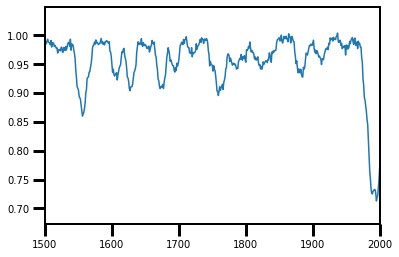

In [115]:
plt.plot(SPECTRA[4])
plt.xlim(1500,2000)

## Interpolating the Wavelengths

In [116]:
maxlen = []
for i in range(len(RM_WAVELENGTH)):
    maxlen.append(len(RM_WAVELENGTH[i]))
print(np.nanmax(maxlen))

4258


In [117]:
FACTOR = 3

INTERPOLATED_WAVELENGTH = np.zeros( (RM_WAVELENGTH.shape[0], 
                                     np.nanmax(maxlen)*FACTOR)  )
INTERPOLATED_SPECTRA = np.zeros( (RM_WAVELENGTH.shape[0], 
                                  np.nanmax(maxlen)*FACTOR)  )

for i, order in enumerate(range(len(RM_WAVELENGTH))):
    iw, iss = grid_wavelength(RM_WAVELENGTH[i], RM_SPECTRA[i], np.nanmax(maxlen)*FACTOR)
    INTERPOLATED_WAVELENGTH[i] = iw
    INTERPOLATED_SPECTRA[i] = iss

In [118]:
INTERPOLATED_SPECTRA.shape

(53, 12774)

## Accounting for stellar RV

In [119]:
star_bc = 16.15 * u.km / u.s
speedlight = 2.998e8 * u.m / u.s
dopshift = ((INTERPOLATED_WAVELENGTH*u.nm * star_bc) / speedlight).to(u.nm)
INTERPOLATED_WAVELENGTH = (INTERPOLATED_WAVELENGTH*u.nm - dopshift).to(u.nm).value

## Saving interpolated data

In [120]:
INTERPOLATED_SPECTRA.shape, INTERPOLATED_WAVELENGTH.shape

((53, 12774), (53, 12774))

In [121]:
INTERPOLATED_SPECTRA.shape

(53, 12774)

In [122]:
np.save(os.path.join(new_science_dir, 'interp_1d_wavelength_order_{}.npy'.format(ORDER_IND)), 
        INTERPOLATED_WAVELENGTH)
np.save(os.path.join(new_science_dir,'interp_1d_spectra_order_{}.npy'.format(ORDER_IND)), 
        INTERPOLATED_SPECTRA)

In [123]:
new_science_dir

'/Users/arcticfox/Downloads/gemini_data/'